# Assignment

pip 3 install all libraries. 

In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install sklearn
!pip3 install textblob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import re
import html

from textblob import TextBlob

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

## 1. Data Cleaning

Before feature extraction, date should be cleaned to obatin better features. Data Pre-processing will be preformed in this section.

First load files from current directory into panda data frame

In [2]:
stops = open("stop_words.txt","r")
stopWords = stops.read().replace('\t','\n').split('\n')
airlineTweets = pd.read_csv("US_airline_tweets.csv")
genericTweets = pd.read_csv("generic_tweets.txt")

Next step is to **Define data cleaning methods:**

Beside the basic cleaning method mentioned in assignent instructions (html, ascii,url,lowercase etc), I also inplemented Spelling correction - removing spelling mistakes that would help reducing multiple copies of words. **Please Note spelling correction has extremly long running time so I ended up commenting it out**.

In [3]:
#Method 1 - Remove all non ASCII charaters such as 'å'
def non_ascii_rm(text):
    allAscii = text.encode("ascii", errors="ignore").decode()
    return allAscii
    
#Method 2 - Remove all html tags and attributes
def html_tag_rm(text):
    noTag = re.compile(r"<.*?>").sub("", text)
    return noTag

#Method 3 - Replace Html character codes with ASCII equivalent
def ascii_rpl(text):
    return(html.unescape(text))

#Method 4 - Remove all URLs
def url_rm(text):
    return(re.compile(r"\w+://\S*").sub("", text))

#Method 5 - Spelling correction
#def spell_correct(text):
#    return(str(TextBlob(text).correct()))

#Method 6 - Remove all stopwords - loaded from stopword.txt
def stop_words_rm(stopWords,text):
    filtered_words = [word for word in text.split(" ") if word not in stopWords]
    return filtered_words

#Wraper function to preform all data cleaning method
def cleanText(text):
    global stopWords
    allAscii = non_ascii_rm(text.lower()) #make sure all lowercase
    noTag = html_tag_rm(allAscii) 
    asciiRpl = ascii_rpl(noTag)
    noUrl = url_rm(asciiRpl)
    #spellCorrect = spell_correct(noUrl)
    #noStopWords = stop_words_rm(stopWords, spellCorrect)
    noStopWords = stop_words_rm(stopWords, noUrl)
    return(" ".join(noStopWords))

**Clean Data using methods defined above**<br>
Cleaned data are saved as csv files in local directory for future usage

In [4]:
cleandata = lambda x: cleanText(x)
genericTweets["text"] = genericTweets["text"].map(cleandata)
airlineTweets["text"] = airlineTweets["text"].map(cleandata)

genericTweets.to_csv("generic_tweets_clean.csv")
airlineTweets.to_csv("US_airline_tweets_clean.csv")

## 2. Exploratory Analysis

To determine the airline of a given tweet, my design is to look are the '@' of each tweets to find the corresponding airlines names. Taking into consideration a tweet can also @ another user instead of the airline, the results are sorting by @ frequency with top 7 results as airline names.

In [5]:
atUser = pd.DataFrame(columns=['atUser'])

#Method to find regex pattern - used for finding "@"s
def getAtUsers(text, pattern):
    return pattern.findall(text)

#find airlines mentioned with "@"
atUserRe = re.compile(r'@\w+')
for t in airlineTweets["text"]:
    for user in getAtUsers(t, atUserRe):
        atUser = atUser.append({"atUser": user},ignore_index=True)
        
#count the number of @s within Airline tweets and find most frequent @
atAirCount = atUser.groupby(["atUser"]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(10)
atAirCount

,atUser,counts
626,@united,3192
636,@usairways,2607
47,@americanair,2462
556,@southwestair,1788
318,@jetblue,1519
648,@virginamerica,344
181,@delta,60
488,@phlairport,17
299,@imaginedragons,17
188,@dfwairport,12



With the frequency data gathered above, a bar chart is created below to show the distrubution of the 7 major Airlines. As a result, **United Airline has the most comments** of 3192 tweets following by Us Airways, and American Air.


Text(0, 0.5, 'Number of Tweets')

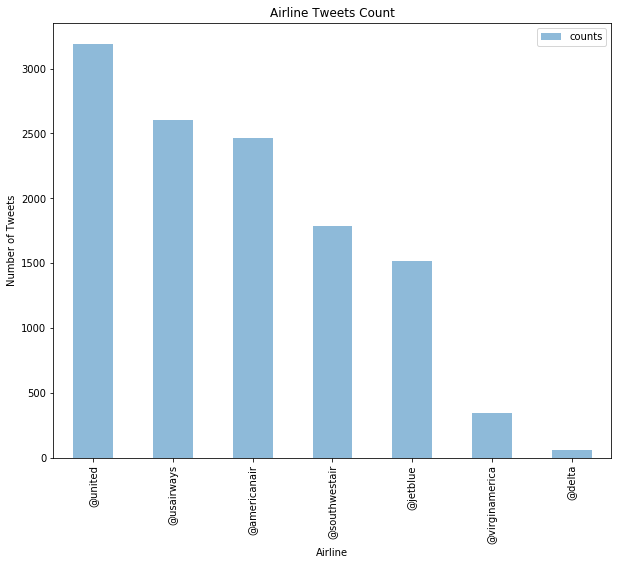

In [6]:
#atAirCount = atAirCount.set_index('atUser')
aa = atAirCount.set_index("atUser")
aa.index.name="Airline"
plot = aa.head(7).plot(kind="bar",alpha=0.5, title="Airline Tweets Count",figsize=(10,8))
plot.set_ylabel("Number of Tweets")

Plot a histograms from generic tweets to see the distribution of tweet useful length (after cleaning) for both positive and negative sentiment score. The resulting distribution is similar with slightly more shorter negative reviews.

Text(0.5, 0.5, 'Number of Tweets')

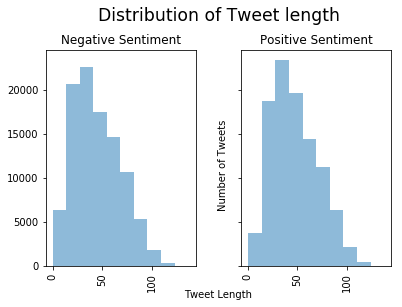

In [7]:
pltRename = genericTweets.copy()
pltRename['class'] = pltRename['class'].apply(lambda x: 'Positive Sentiment' if x > 0 else 'Negative Sentiment')
pltRename['length'] = pltRename['text'].apply(len)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
pltRename.hist('length',by='class',alpha=0.5,ax=axes)

plt.suptitle('Distribution of Tweet length', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Tweet Length', ha='center')
fig.text(0.5, 0.5, 'Number of Tweets', va='center', rotation='vertical')


## 3. Model Preparation

Generic tweets are splited into 70% Training data and 30% Test data. **Word frequency** is used as the deatrues of the model.

The pros of using this model includes:
    -  Easy to scale
    -  fast development
    -  robust
 
The cons are:
    -  Requires large annotation
    -  may be difficult to debug
    -  fail in short messages
    -  only shallow NLP

In [8]:
genClean = pd.read_csv("generic_tweets_clean.csv")
airClean = pd.read_csv("US_airline_tweets_clean.csv")

In [9]:
#Adding a deepclean method to slightly increase model accuracy
def deepClean(text):
    text = str(text)
    #remove @
    #text = re.sub(r'@\S+', '', text)
    #remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove number
    text = re.sub(r'\b\d+\b', '', text)
    return text

cleandata = lambda x: deepClean(x)
genClean["text"] = genClean["text"].map(cleandata)
airClean["text"] = airClean["text"].map(cleandata)
    

In [10]:
#Prepare feature - word frequency
cv = CountVectorizer(binary=True)
cv.fit(genClean.text)
X = cv.transform(genClean.text)
target = genClean["class"]

#Split generic tweet into 70% train and 30% test
X_train, X_val, y_train, y_val = train_test_split(X, target , test_size=0.3, random_state=42)

## 4. Model Implementation

Training the logistric regreassion model with 70% training data and apply to test data fron generic tweets to obtain the highest achievable accuracy by testing different c values. C = 0.5 is select based on testing results. <br>

Because the sentiment in airline tweet are marked as "positive" and "negative" instead of numeric value, I'm also renaming "positive" to "4" and negative to "0" to match the values in generic tweets.

Apply the model to airline tweets and obtained a accuracy of **75.4%**

In [11]:
#finding best C value for LR with 70% training data and apply to test data
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

#prepare airline feature
X_test = cv.transform(airClean.text)
y_test_target = [4 if s == "positive" else 0 for s in airClean.sentiment]

#use the same model to test data with accuracy obtained below
model_b = LogisticRegression(C=0.5)
model_b.fit(X_train, y_train)
print ("\nAccuracy of Model on airline Tweets: %s\n" 
       % accuracy_score(y_test_target, model_b.predict(X_test)))

print("Confusion Matrix:")
print(confusion_matrix(y_test_target,model_b.predict(X_test)))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.72425
Accuracy for C=0.05: 0.7375333333333334
Accuracy for C=0.25: 0.7425166666666667
Accuracy for C=0.5: 0.7427166666666667
Accuracy for C=1: 0.7415833333333334

Accuracy of Model on airline Tweets: 0.7540074516939607

Confusion Matrix:
[[6893 2285]
 [ 554 1809]]


To slightly improve the accuracy, re-train the model with 100% generic tweets and apply to airline data and obtained a higher accuracy **75.8%** <br>

Confusion Matrix of new model is [[6925 2253][536 1827]]

Top 10 Positive and Negetive Words are obtained. A a interesting result, **followfriday** is the Top 1 positive word which is also understandable since it is a very popular & friendly hashtag on tweeter. *Follow Friday is when, on a Friday, people show each other some Twitter love, by recommending to their followers who they recommend to follow. It was invented by Twitter users. And it's usually preceded by the hash sign – as in #FF or #FollowFriday.*

In [12]:
#Now build the LR model 100% data from Generic tweets
final_model = LogisticRegression(C=0.5)
final_model.fit(X, target)

prediction = final_model.predict(X_test)
print(prediction.)
print ("Improved Accuracy with model trained with 100 generic tweet data: %s\n" 
       % accuracy_score(y_test_target, prediction))

print(classification_report(y_test_target,prediction))
print("Confusion Matrix:")
print(confusion_matrix(y_test_target,prediction))

#print freq words
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}

print("\nTop 10 Positive Word")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)

print("-------------------------------\n Top 10 Negative Word")

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)

88888768786876868
[0 4 0 ... 0 0 0]
Improved Accuracy with model trained with 100 generic tweet data: 0.7583398319036478

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      9178
           4       0.45      0.77      0.57      2363

   micro avg       0.76      0.76      0.76     11541
   macro avg       0.69      0.76      0.70     11541
weighted avg       0.83      0.76      0.78     11541

Confusion Matrix:
[[6925 2253]
 [ 536 1827]]

Top 10 Positive Word
('followfriday', 1.9508693115208233)
('welcome', 1.9429420303342138)
('yayy', 1.838907084598249)
('congratulations', 1.8387150042190867)
('smiling', 1.8240324975355557)
('thankyou', 1.7599389482298629)
('smile', 1.7058380951129575)
('blessed', 1.7022632668261246)
('pleasure', 1.6790047586114887)
('thx', 1.6244011804267375)
-------------------------------
 Top 10 Negative Word
('sad', -3.1207758490957187)
('sadly', -2.93857625127804)
('mothers', -2.6584927963356413)
('bummed', -2.

**Negative** US airline tweets are selected by removing tweets with no "negative_reason". The negative tweets are divided into 70% training and 30% Testing data and a multi-class logistic regression model are built. **Word frequncy** analysis is used.

In [13]:
dfReasons = airClean.query('negative_reason == negative_reason').copy()

#atUser.groupby(["atUser"]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(10)
#reasons = dfReasons.negative_reason.unique()
#print(dfReasons.shape)
#print(le.fit_transform(dfReasons["negative_reason"]).shape)

le = preprocessing.LabelEncoder()
dfReasons["negative_reason"] = le.fit_transform(dfReasons["negative_reason"])


cv = CountVectorizer(binary=True)
cv.fit(dfReasons.text)
X = cv.transform(dfReasons.text)
target = dfReasons.negative_reason

X_train, X_val, y_train, y_val = train_test_split(X, target , test_size=0.3, random_state=42)

final_model = LogisticRegression(C=0.1, solver='lbfgs',
                         multi_class='multinomial')
final_model.fit(X_train, y_train)

prediction2 = final_model.predict(X_val)
print ("Final Accuracy: %s" 
       % accuracy_score(y_val, prediction2))

print(classification_report(y_test_target,prediction))
print("Confusion Matrix:")
print (confusion_matrix(y_val,prediction2))


Final Accuracy: 0.6082062454611474
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      9178
           4       0.45      0.77      0.57      2363

   micro avg       0.76      0.76      0.76     11541
   macro avg       0.69      0.76      0.70     11541
weighted avg       0.83      0.76      0.78     11541

Confusion Matrix:
[[ 43  25   0  45   0   3   4  35   4   0]
 [  8 170   3 144   0   1   1  25   7   0]
 [  1  14 184  39   0   0   1  18   4   0]
 [  6  77  25 697   0   8  17  32  13   0]
 [  0   1   0   5   0   0   0   0  14   0]
 [  6  12   0  65   0  25   1  18  10   0]
 [  4  18   6  77   0   1  29   8   2   0]
 [  8  50   9  64   0   1   2 375   8   0]
 [  0  18   0  33   0   2   0  21 151   1]
 [  5   4   2  18   0   0   0  19   6   1]]


answer the research question stated above based on the outputs of your first model. Some people were wondering why they should analyze the sentiments of the airline tweets based on the prediction of the logistic regression model if the ground truth labels were already given. The goal of the assignment is to perform sentiments analysis from generic tweets and use the result to analyze US airline tweets. Therefore, you should discuss the result from the sentiment analysis as if the ground truth labels were not given. These labels were only provided as a reference so you have a sense of whether your logistic regression model was working.

## 5. Discussion

**“What can public opinion on Twitter tell us about the US airlines in 2015?”** <br>

Only looking at the number of tweets, **United Airline** seems to be the most popular airline in 2015 since it has the most comments of 3192 tweets following by Us Airways, and American Air. 

Among the negative reviews, **customer service Issue** received the most number of complaints. A big portion of the complaints are regarding issues for online/phone/website support. Customers are expecting prompt reply when they encourted problems with booking/managing their flights. Long wait time before reaching support team would result in negative tweets. The second most popular negative review reason is **Late Flght**.

Similar result can be obtained from the Top 10 Positive and Negative words (in bonus section below). **"canceled"**, **"late"** and **"delayed"** are the top *Negative* words, which tells us that a timely operation is very important for airline customers in 2015. For the *positive* words, **"wifi"** scored a 1.55 which is significatly higher than the rest of positive words. It shows **a good wifi could potential improve customer experience by a lot**.

Based on the output of the first model

**Prediction Examples**<br>
From the confusion matrix of the second model, we can see it failed to classify all tweets with the reason **"damaged luggage"**. The failure of prediction could be the reason of insufficient Training data, since there were only 74 entry in total with "damaged luggage". Since the model was built with word frequency, insufficient data could result in missing key words when calculating sentiment score. 

For example, "@USAirways Oh yes, because I had loads of time running to my connecting flight after you delayed me for about 90 minutes...!" is a tweet with "damaged luggage" which the model failed to predict. There were no key word related to "luggage", "baggage" or "damage" but has the key word "delayed" which is closer to the reason of "late flight"

"@AmericanAir haha I did. They said it wasn't their fault somehow? You guys r a joke!" and "@AmericanAir how do I see your report team?!" are a tweet the model failed to predict due to similar reasons. 

**Improve Model Accuracy**<br>
There are many ways to improve the accuracy of the model, examples including:

1. **Better data cleaning**: Preform better pre-processing of the data will help to extract better features from clean data. Some methods that was not implemented in this project such as:
    -  removing rare words: Since these works are so rarly used, the association between them and other workds is dominated by noise. It will be usedul to replace rare words with a more general form to have higher counts
    -  Stemming: remove suffices such as "es", "s","ed" to reduce multiple copies of same words
    -  Lemmatization: converting words into root word also to reduce multiple copies of same words.<br><br>
    
2. Test with other text processing model such as **N-grams** which is to combining multiple works together.<br><br>

3. **Increase data size**: Similar to what was demonstrated in **Question 4 Model Inplementation**, more data could result in improved accuracy. The model trained with 70% generic tweets obtained a accuracy of **75.1%** when applied to airline tweets; while the model trained with 100% generic tweets obtained a slightly higher accuracy of  **75.8%**<br><br>

4. **Evaluate the data collected**: Generic tweets data has a more balanced negative and positive reviews. However the airline tweets tend to be more biased with a lot more negative tweets which could protentially effect the model accuracy. **Stratified split** in sklearn can be used to shuffle and split data to account for class imbalance problem. **GridSearch** is also a technique can be used as well.


## Bonus

**Look for the Top 10 Positive and Negative words by analyzing Airline Tweets data.**

**"canceled"**, **"late"** and **"delayed"** are the top *Negative* words, which tells us that a timely operation is very important for airline customers in 2015. For the *positive* words, **"wifi"** scored a 1.55 which is significatly higher than the rest of positive words. It shows **a good wifi could potential improve customer experience by a lot**. Other features like big **"seat"** space, **"tv""** and also **"food"** offered on plane would also improve customer experience.

In [14]:
#print freq words
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}

print("-------------------------------\nTop 10 Positive Word")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)

print("-------------------------------\n Top 10 Negative Word")

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)

-------------------------------
Top 10 Positive Word
('wifi', 1.5542879400379268)
('seat', 1.0767590935301128)
('plane', 1.02162554623528)
('seats', 0.9079506218176506)
('tv', 0.7362806401447026)
('planes', 0.5654249442897915)
('landing', 0.5271930383390225)
('flight', 0.5121620688823967)
('class', 0.4902950195010596)
('food', 0.42939618666095497)
-------------------------------
 Top 10 Negative Word
('cancelled', -0.6380523401965521)
('late', -0.46359802101588377)
('hours', -0.46118774397582146)
('delayed', -0.4476821178451489)
('bag', -0.37091940028401765)
('airport', -0.35958086233654657)
('help', -0.3516744368353899)
('phone', -0.3393041805200876)
('hold', -0.33870580887941976)
('customers', -0.3177442842661544)


In [15]:
atUserScore = pd.DataFrame(columns=['atUser','score'])

#find airlines mentioned with "@"
atUserRe = re.compile(r'@\w+')
for index, row in airlineTweets.iterrows():
    t = row.text
    sen = row.sentiment
    for user in getAtUsers(t, atUserRe):
        atUserScore = atUserScore.append({"atUser": user, "score": sen},ignore_index=True)

In [16]:
userGroup = atUserScore.groupby(["atUser", "score"])
divided = userGroup.size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(12).sort_values(by=["atUser"])
allNegative = divided["score"] == "negative"
allNegative = divided[allNegative]
allPositive = divided["score"] == "positive"
allPositive = divided[allPositive]

**Plot showing the number of positive and negative tweets for each airlines**

Tweets for each airline are extracted and divided into positive and negative tweets. A bar chart below shows the number of positve and negative tweets for each airline. From the diagram we can clearly see that **People tends to tweet more for negative experiences rather than positive in 2015.** For example, there were only 275 positive tweets for Us Airways while 2332 negative reviews; 353 positive and 2109 negative tweets for American Air.

Only looking at the number of tweets, **United Airline** seems to be the most popular airline in 2015 since it has the most comments of 3192 tweets following by Us Airways, and American Air. However, looking into the number of negative and positive tweets, we may now say it is the most "hated" Airline in 2015 since it also has the highest number of negative reviews.

Surprisingly, **the low cost airlines like Virgin, jet blue and south west seems to have better review score** (looking at the ratio between number of positive and negative tweets) **comparing to the other major airlines.** **Virgin America** is the most balanced airline with 191 negative and 153 positive reviews.

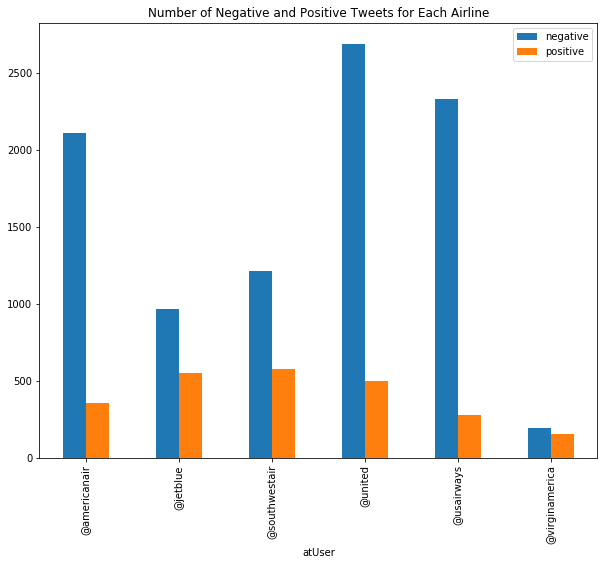

In [17]:
aTweets = pd.DataFrame(index = divided["atUser"].drop_duplicates())
aTweets["negative"] = allNegative["counts"].values
aTweets["positive"] = allPositive["counts"].values
aTweets.plot(kind='bar',title = "Number of Negative and Positive Tweets for Each Airline",figsize=(10,8))